In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import json
from os.path import join as pjoin
from itertools import product, permutations
from tqdm import tqdm as tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
from sympy.utilities.iterables import multiset_permutations
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres
from hierarch.resampling import Bootstrapper

# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240215-16:57:24,241 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.num_rois = 58
args.roi_size = 600
args.maintain_symmetry = True
args.brain_div = 'whl'

DESC = (
    f'type-functional'
    f'_nrois-{args.num_rois}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
)

args.num_comms = 11
args.thresh = 0.15
args.num_resamples = 50

PARCELS_path = f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/MouseConnectivity/parcels'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
COMM_path = f'{BASE_path}/{DESC}/svinets/k-{args.num_comms}'
NPY_path = f'{BASE_path}/{DESC}/npy_files'
ESTM_path = f'{BASE_path}/{DESC}/estimates'
os.system(f'mkdir -p {ESTM_path}')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
import glob

def get_dataset(args, files):
    def get_comms(file):
        comms_ = np.loadtxt(file)
        comms = np.zeros((args.num_rois, args.num_comms))
        comms[comms_[:, 1].astype(int), :] = comms_[:, 2:]
        return comms

    dataset_df = []

    for file in tqdm(files):
        ssr = file.split('/')[-3].split('_')
        seed = file.split('/')[-2].split('-')[-1]
        # if int(seed) > 25: continue
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'seed':[int(seed)], 
            'mem_mat':[get_comms(file)],
        })
        dataset_df.append(df)
    dataset_df = pd.concat(dataset_df)
    return dataset_df.sort_values(
        by=['sub', 'ses', 'run', 'seed'],
    ).reset_index(drop=True)

dataset_ssrs_df = get_dataset(
    args, 
    files=glob.glob(f'{COMM_path}/**/groups.txt', recursive=True)
)
# dataset_ssrs_df

  0%|          | 0/11600 [00:00<?, ?it/s]

100%|██████████| 11600/11600 [00:05<00:00, 2300.35it/s]


In [6]:
args.num_subs = len(dataset_ssrs_df['sub'].unique())
args.num_sess = len(dataset_ssrs_df['ses'].unique())

In [7]:
def reference_comms(args, X):
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50,
        random_state=args.SEED
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, X):
    comm_cntrs = reference_comms(args, X)
    
    for idx, comms in tqdm(enumerate(X)):
        (
            comms, 
            best_pi,
        ) = align_two_partitions(
            args, 
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        X[idx] = comms * (comms > args.thresh)
        X[idx] = np.round(X[idx], decimals=3)
    return X

def bootstrap(args, df, cols, estim_cols):
    mdf = df.set_index(cols)
    index = np.array(mdf.index.to_list())
    index = index if index.ndim > 1 else np.expand_dims(index, axis=-1)
    index = np.hstack([index, np.ones((len(df),1))])
    
    boot = Bootstrapper(random_state=args.SEED, kind='indexes')
    boot.fit(index, skip=None)
    boot_means = [[] for _ in estim_cols]
    for _ in np.arange(args.num_resamples):
        index_boot = np.squeeze(boot.transform(index, start=0)[:, :-1]).tolist()
        mdf_ = mdf.loc[index_boot]
        for idx, estim_col in enumerate(estim_cols):
            estim = mdf_[estim_col].values
            boot_means[idx].append(np.mean(estim))
    return boot_means

def get_statistic(args, df, estim_cols):
    estims = []
    for idx, estim_col in enumerate(estim_cols):
        estim = np.mean(df[estim_col].to_list(), axis=0)
        estims.append(estim)
    return estims

def rescale(X):
    X /= np.expand_dims(np.sum(X, axis=-1), axis=-1)
    X = np.nan_to_num(X)
    X = np.round(X, decimals=3)
    return X

def combine_within_df_groups(
    args, main_df, 
    fixed_cols=['sub', 'ses', 'run'],
    index_cols=['sub', 'ses', 'run', 'seed'], 
    estim_cols=['mem_mat'],
):
    groups = main_df.groupby(by=fixed_cols)
    dfs = []
    for key, group in tqdm(groups):
        key = [key] if not type(key) == tuple else list(key)
        assert len(key) == len(fixed_cols)
        var_cols = [
            c 
            for c in index_cols 
            if c not in fixed_cols
        ] # variable cols in the index
        
        '''
        X = bootstrap(
            args, 
            df=group,
            cols=var_cols,
            estim_cols=estim_cols,
        )
        X = [np.mean(x, axis=0).round(3) for x in X]
        X = [rescale(x) for x in X]
        '''
        X = get_statistic(
            args, 
            df=group,
            estim_cols=estim_cols,
        )
        X[0] = rescale(X[0])
        
        data = key + X
        cols = fixed_cols + estim_cols
        df = pd.DataFrame({
            k:[v] 
            for k, v in zip(cols, data)
        })
        dfs.append(df)
    dataset_df = pd.concat(dfs)
    return dataset_df.reset_index(drop=True)

In [8]:
dataset_ssrs_df['mem_mat'] = align_partitions(args, dataset_ssrs_df['mem_mat'].to_list())

found reference


11600it [00:17, 654.85it/s]


In [9]:
main_df = dataset_ssrs_df
estim_cols = ['mem_mat']
index_cols = [c for c in main_df.columns if c not in estim_cols]
estim_cols, index_cols

(['mem_mat'], ['sub', 'ses', 'run', 'seed'])

In [10]:
args.binwidth = 0.2
args.binrange = [0.2, 1.0]
def membership_proportions(X):
    bins = int((args.binrange[1] - args.binrange[0]) / args.binwidth)
    H = []
    for idx_comm in range(args.num_comms):
        y, _ = np.histogram(X[:, idx_comm], bins=bins, range=args.binrange)
        y = y / np.sum(y)
        H.append(y)
    H = np.nan_to_num(H)
    H = np.array(H).round(3)
    x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)
    return H # num_comms x num_bins

main_df['hist_props'] = main_df['mem_mat'].apply(membership_proportions)
estim_cols += ['hist_props']
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]

In [11]:
def entropy(X):
    return stats.entropy(X, base=2, axis=-1) / np.log2(args.num_comms)

main_df['entropy'] = main_df['mem_mat'].apply(entropy)
estim_cols += ['entropy']
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]

In [12]:
print(index_cols, estim_cols)

# animal/subj level estimates
dataset_s_df = combine_within_df_groups(
    args, 
    main_df=main_df,
    fixed_cols=['sub',],
    index_cols=index_cols,
    estim_cols=estim_cols
)

['sub', 'ses', 'run', 'seed'] ['mem_mat', 'hist_props', 'entropy']


100%|██████████| 10/10 [00:00<00:00, 162.88it/s]


['sub', 'ses', 'run', 'seed'] ['mem_mat', 'hist_props', 'entropy']


240215-16:58:22,584 nipype.interface INFO:
	 stderr 2024-02-15T16:58:22.584120:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240215-16:58:22,587 nipype.interface INFO:
	 stderr 2024-02-15T16:58:22.587190:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240215-16:58:22,588 nipype.interface INFO:
	 stderr 2024-02-15T16:58:22.588878:*+ WARNING: Set TR of output dataset to 1.0 s
240215-16:58:22,713 nipype.interface INFO:
	 stderr 2024-02-15T16:58:22.713761:++ elapsed time = 0.1 s


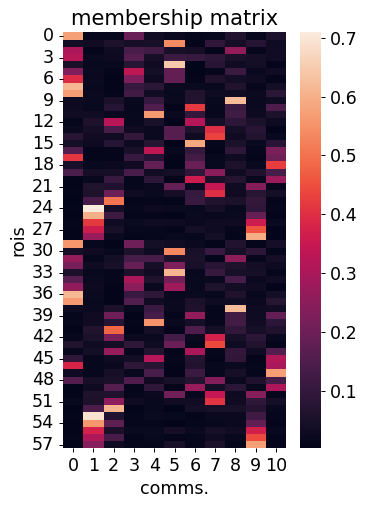

In [13]:
# group level estimates
index_cols = [c for c in main_df.columns.to_list() if c not in estim_cols]
print(index_cols, estim_cols)

X_grp_lvl = get_statistic(
    args, 
    df=main_df,
    estim_cols=estim_cols,
)
X_grp_lvl[0] = rescale(X_grp_lvl[0])


# visualize mem. mat.
fig, axs = plt.subplots(1, 1, figsize=(4, 6), dpi=90)
ax = axs
sns.heatmap(X_grp_lvl[0], ax=ax)
ax.set(title='membership matrix', xlabel='comms.', ylabel='rois')


# save as nifti
for comm in range(args.num_comms):
    comms_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        comms_img += (parcels == roi) * X_grp_lvl[0][idx, comm]

    parcels_img.new_image_like(
        comms_img
    ).to_filename(f'{ESTM_path}/comm{comm}.nii.gz')

out_file = f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-meam_mbr.nii.gz'
try:
    os.remove(out_file)
except:
    pass

tcat = afni.TCat()
tcat.inputs.in_files = [
    f'{ESTM_path}/comm{comm}.nii.gz'
    for comm in range(args.num_comms)
]
tcat.inputs.out_file = out_file
tcat.inputs.rlt = ''
tcat.cmdline
res = tcat.run()

for comm in range(args.num_comms):
    try:
        os.remove(f'{ESTM_path}/comm{comm}.nii.gz')
    except:
        pass

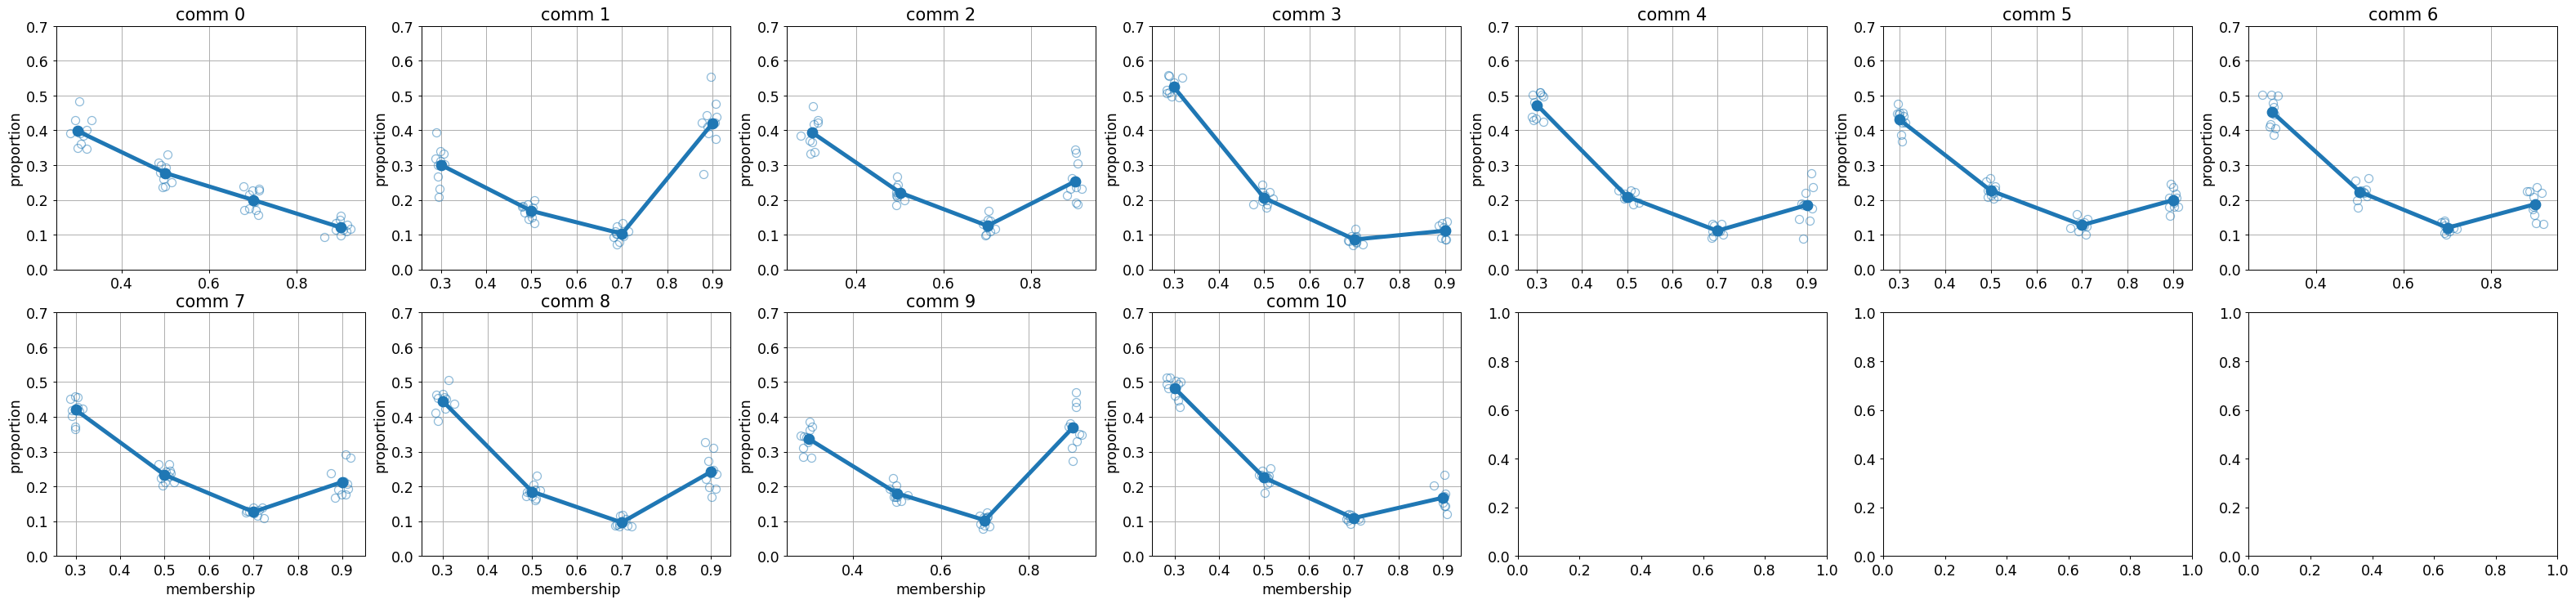

In [14]:
# MEMBERSHIP HISTOGRAMS
props_grp_lvl = X_grp_lvl[1] # comms x bins
props_subj_lvl = np.stack(dataset_s_df['hist_props'].values, axis=-1) # comms x bins x subs

x = np.arange(args.binrange[0]+args.binwidth/2, args.binrange[1], args.binwidth)

ncols = 7 
nrows = int(np.ceil((args.num_comms / ncols)))
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(5*ncols, 4*nrows), dpi=90, 
    sharex=False, sharey=False
)
fig.tight_layout()
for idx_comm in range(args.num_comms):
    ax = axs[idx_comm // ncols, idx_comm % ncols] if nrows > 1 else axs[idx_comm]
    ax.plot(x, props_grp_lvl[idx_comm, :], linewidth=4, markersize=10, marker='o', linestyle='-')
    for idx_sub in range(args.num_subs):
        x_ = x + 0.01*np.random.randn(x.shape[0])
        ax.plot(
            x_, props_subj_lvl[idx_comm, :, idx_sub], 
            linewidth=2, linestyle='', 
            markersize=8, marker='o', fillstyle='none',
            alpha=0.5, color='tab:blue'
        )
    ax.set(title=f'comm {idx_comm}', ylabel='proportion', ylim=[0.0, 0.7])
    if idx_comm // ncols == nrows-1: ax.set(xlabel='membership')
    ax.grid(True)

<Axes: ylabel='Proportion'>

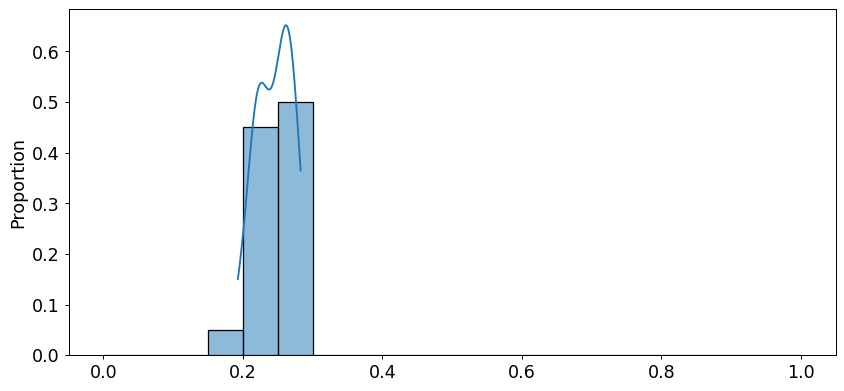

In [15]:
# MEMBERSHIP ENTROPIES
# save as nifti
ent = X_grp_lvl[2]
ent_img = np.zeros_like(parcels)
for idx, roi in enumerate(roi_labels):
    ent_img += (parcels == roi) * ent[idx]
parcels_img.new_image_like(
    ent_img
).to_filename(f'{ESTM_path}/{DESC}_k-{args.num_comms}_desc-entropy.nii.gz')

fig, axs = plt.subplots(1, 1, figsize=(11, 5), dpi=90)
ax = axs
sns.histplot(ent, stat='proportion', binrange=[0.0, 1.0], binwidth=0.05, kde=True)

In [16]:
main_df

,sub,ses,run,seed,mem_mat,hist_props,entropy
0,1,1,1,1,"[[0.325, 0.0, 0.0, 0.0, 0.159, 0.0, 0.161, 0.0...","[[0.467, 0.4, 0.133, 0.0], [0.25, 0.5, 0.0, 0....","[0.5587534057390997, 0.0, 0.2687956624852164, ..."
1,1,1,1,2,"[[0.172, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.2, 0.4, 0.2, 0.2], [0.143, 0.286, 0.0, 0.5...","[0.22533445544401623, 0.0, 0.2835306854320583,..."
2,1,1,1,3,"[[0.174, 0.0, 0.0, 0.185, 0.0, 0.0, 0.0, 0.0, ...","[[0.333, 0.222, 0.333, 0.111], [0.667, 0.0, 0....","[0.4219568190417648, 0.0, 0.24994384816784676,..."
3,1,1,1,4,"[[0.0, 0.0, 0.0, 0.0, 0.165, 0.0, 0.0, 0.0, 0....","[[0.6, 0.3, 0.1, 0.0], [0.286, 0.0, 0.286, 0.4...","[0.23399226856470615, 0.23634812696885607, 0.2..."
4,1,1,1,5,"[[0.211, 0.0, 0.0, 0.761, 0.0, 0.0, 0.0, 0.0, ...","[[0.2, 0.3, 0.3, 0.2], [0.75, 0.25, 0.0, 0.0],...","[0.21818507902442708, 0.0, 0.26804347066786605..."
...,...,...,...,...,...,...,...
11595,10,3,7,96,"[[0.276, 0.0, 0.0, 0.434, 0.0, 0.0, 0.0, 0.0, ...","[[0.545, 0.364, 0.0, 0.091], [0.5, 0.0, 0.0, 0...","[0.4311974041791098, 0.0, 0.0, 0.4312789742470..."
11596,10,3,7,97,"[[0.425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.292, ...","[[0.636, 0.182, 0.182, 0.0], [0.357, 0.214, 0....","[0.43910830881070684, 0.0, 0.0, 0.0, 0.2862922..."
11597,10,3,7,98,"[[0.548, 0.0, 0.0, 0.225, 0.0, 0.0, 0.203, 0.0...","[[0.5, 0.333, 0.167, 0.0], [0.286, 0.143, 0.28...","[0.41242504783717604, 0.26574342492445535, 0.2..."
11598,10,3,7,99,"[[0.456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.5, 0.3, 0.1, 0.1], [0.375, 0.25, 0.125, 0....","[0.27559899502453006, 0.27065045706150476, 0.0..."
